In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import cv2
from lxml import etree
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import transforms, datasets, models

from draw import show_img
from utils import bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh

from imgaug import augmentors as iaa
import numpy as np

# Preprocess Image

In [2]:
def letterbox_transforms(inner_dim, outer_dim):
    outer_w, outer_h = outer_dim
    inner_w, inner_h = inner_dim
    ratio = min(outer_w / inner_w, outer_h / inner_h)
    box_w = int(inner_w * ratio)
    box_h = int(inner_h * ratio)
    box_x_offset = (outer_w // 2) - (box_w // 2)
    box_y_offset = (outer_h // 2) - (box_h // 2)
    return box_w, box_h, box_x_offset, box_y_offset, ratio

def letterbox_image(img, dim):
    #Create the background
    image = np.full(dim +(3,), 128)
        
    img_dim = (img.shape[1], img.shape[0])
    box_w, box_h, box_x, box_y, ratio = letterbox_transforms(img_dim, dim)
    box_image = cv2.resize(img, (box_w,box_h), interpolation = cv2.INTER_CUBIC)
        
    #Put the box image on top of the blank image
    image[box_y:box_y+box_h, box_x:box_x+box_w] = box_image
    
    transform = Tensor([box_w, box_h, box_x, box_y, ratio])
    return image, transform

# Mode - letterbox, resize
def load_image(img_path, mode=None, dim=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_org_dim = (img.shape[1], img.shape[0])
    trans = None
    if mode is not None and dim is not None:
        if mode == 'letterbox':
            img, trans = letterbox_image(img, dim)
        elif mode == 'resize':
            img = cv2.resize(img, dim)
    
    img = torch.from_numpy(img).float().permute(2,0,1) / 255
    return img, img_org_dim, trans

# Dataset

In [3]:
def letterbox_label(label, transform, dim):
    label_x_offset = transform[..., 2] / dim[0]
    label_y_offset = transform[..., 3] / dim[1]
    box_w_ratio = transform[..., 0] / dim[0]
    box_h_ratio = transform[..., 1] / dim[1]
    label[..., [0,2]] = label[..., [0,2]] * box_w_ratio 
    label[..., [1,3]] = label[..., [1,3]] * box_h_ratio
    label[..., 0] = label[..., 0] + label_x_offset
    label[..., 1] = label[..., 1] + label_y_offset
    return label

def letterbox_label_reverse(label, transform, dim):
    label_x_offset = transform[..., 2] / dim[0]
    label_y_offset = transform[..., 3] / dim[1]
    box_w_ratio = transform[..., 0] / dim[0]
    box_h_ratio = transform[..., 1] / dim[1]
    label[..., 0] = label[..., 0] - label_x_offset
    label[..., 1] = label[..., 1] - label_y_offset
    label[..., [0,2]] = torch.clamp(label[..., [0,2]] / box_w_ratio, 0, 1) 
    label[..., [1,3]] = torch.clamp(label[..., [1,3]] / box_h_ratio, 0, 1)
    return label

def fill_label_np_tensor(label, row, col):
    label_tmp = np.full((row, col), 0.0)
    if label is not None:
        length = label.shape[0] if label.shape[0] < row else row
        label_tmp[:length] = label[:length]
    return label_tmp   

In [4]:
def get_xml_labels(xml_path):
    labels = OrderedDict()
    
    tree = etree.parse(xml_path)
    root = tree.getroot() 
    
    img_tags = root.xpath("image")

    for image in img_tags:
        img = image.get('name', None)
        labels[img] = []
        for box in image:
            cls = box.get('label', None)
            x1 = box.get('xtl', None)
            y1 = box.get('ytl', None)
            x2 = box.get('xbr', None)
            y2 = box.get('ybr', None)
            labels[img] += [{'cls' : cls, 
                             'x1'  : x1 ,
                             'y1'  : y1 ,
                             'x2'  : x2 ,
                             'y2'  : y2  }]
    return labels

In [5]:
class CVATDataset(Dataset):
    def __init__(self, img_dir, label_xml_path, dim=None):
        self.img_dir = img_dir
        self.label_xml_path = label_xml_path
        self.xml_dict = list(get_xml_labels(self.label_xml_path).items())
        self.dim = dim
        self.class2id = { 'x_wing': 0, 'tie': 1}
        self.id2class = {v:k for k,v in self.class2id.items()}
        self.is_train = True
        
    def __len__(self):
        return len(self.xml_dict)
    
    def isTrain(self, is_train):
        self.is_train = is_train
        return self
    
    def __getitem__(self, idx):
        if self.is_train:
            return self.__getitem_train(idx)
        else:
            return self.__getitem_eval(idx)
    
    def __getitem_eval(self, idx):
        img_path, label = self.xml_dict[idx]
        img_path = osp.join(self.img_dir, img_path)
        if osp.exists(img_path):
            img, img_org_dim, trans = load_image(img_path, mode=None, dim=self.dim)
        return img
    
    def __getitem_train(self, idx):
        label = None
        img_path, label = self.xml_dict[idx]
        
        img_path = osp.join(self.img_dir, img_path)
        if osp.exists(img_path):
            org_img = cv2.imread(img_path)
            org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
            letterbox_img, transform = letterbox_image(org_img, self.dim)
            
            org_img = torch.from_numpy(org_img).float().permute(2,0,1) / 255
            letterbox_img = torch.from_numpy(letterbox_img).float().permute(2,0,1) / 255
        
        org_w, org_h = org_img.shape[2], org_img.shape[1]
        label = torch.from_numpy(np.array( [ [self.class2id[l['cls']],
                                             l['x1'],
                                             l['y1'],
                                             l['x2'],
                                             l['y2'] ] for l in label] ).astype(np.float))
        
        label_bbox = label[..., 1:5]
        label_bbox[..., [0,2]] /= org_w
        label_bbox[..., [1,3]] /= org_h
        label_bbox = bbox_x1y1x2y2_to_cxcywh(label_bbox)

        label = label.double()
        transform = transform.double()
        
        if label is not None:
            label_bbox = letterbox_label(label_bbox, transform, self.dim)

        label = fill_label_np_tensor(label, 50, 5)
        label = torch.from_numpy(label)
        
        sample = { 'org_img': org_img,
                   'letterbox_img': letterbox_img,
                   'transform': transform,
                   'label': label,
                   'img_path': img_path}
        
        return sample

In [6]:
def cv2_drawTextWithBkgd(img, text, bt_left_pt, color, max_x, max_y, font_scale=2.0, font=cv2.FONT_HERSHEY_PLAIN):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, fontScale=font_scale, thickness=1)[0]
        
    t_pt1 = np.clip(bt_left_pt[0], 0, max_x - text_width), np.clip(bt_left_pt[1], text_height, max_y) 
    t_pt2 = t_pt1[0] + text_width, t_pt1[1] - text_height
    
    img = cv2.rectangle(img, t_pt1, t_pt2, color, cv2.FILLED, 4)
    img = cv2.putText(img, text, t_pt1, cv2.FONT_HERSHEY_PLAIN, fontScale=font_scale, color=(0, 0, 0), thickness=2);
    return img

def get_color_pallete(num_color):
    cmap = plt.get_cmap('tab20b')
    colors = Tensor([cmap(i) for i in np.linspace(0, 1, num_color)])
    bbox_colors = colors[torch.randperm(num_color)]
    return bbox_colors

def test_dataset(dataloader, output_dir, classes_names):
    font_scale = 2.0
    font = cv2.FONT_HERSHEY_PLAIN
    
    bbox_colors = get_color_pallete(20)
    
    with torch.no_grad(): 
        for batch, sample in enumerate(train_dl):
            if batch != 16:
                continue
            
            for img, transform, labels, img_path in zip(sample['org_img'], sample['transform'], sample['label'], sample['img_path']):
                img = np.ascontiguousarray(img.numpy().transpose(1, 2, 0))
                img_w, img_h = img.shape[1], img.shape[0]

                for l in labels:
                    if l.sum() == 0:
                        break;
                        
                    box_coord = l[1:5]
                    cls = l[0]
                    
                    cls_text = classes_names[cls.int().item()]
                    cls_color = bbox_colors[cls.int()].numpy().tolist()
                    
                    box_coord = letterbox_label_reverse(box_coord, transform, train_ds.dim)
                    box_coord = bbox_cxcywh_to_x1y1x2y2(box_coord)
                    box_coord[[0,2]] = box_coord[[0,2]] * img_w
                    box_coord[[1,3]] = box_coord[[1,3]] * img_h

                    pt1 = tuple(box_coord[0:2].int().numpy().tolist())
                    pt2 = tuple(box_coord[2:4].int().numpy().tolist())
                    
                    img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
                    img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img_w, img_h, font_scale=font_scale, font=font)
                    
                img = (img * 255).astype(np.int)
                show_img(img, figsize=(16,8))
                cv2.imwrite(osp.join(output_dir, os.path.basename(img_path)), img)
                #break
                 
            break

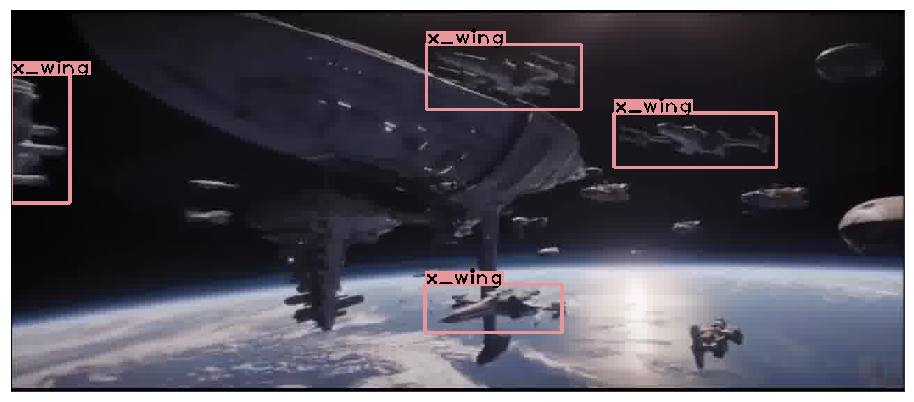

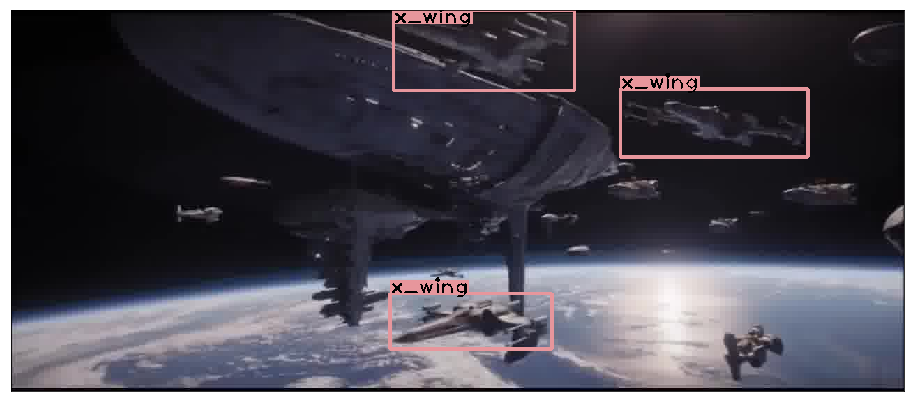

In [7]:
sz = 416
bs = 2
dim = (sz, sz)
cvat_img_dir = './custom_data/x_wing'
label_xml_path = './custom_data/7_x_wing.xml'
output_dir = './output'
classes_path = './x_wing.names'
classes_names = ['x_wing', 'tie']

train_ds = CVATDataset(cvat_img_dir, label_xml_path, dim=dim)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False, num_workers=4)

test_dataset(train_dl, output_dir, classes_names)

(<matplotlib.axes._subplots.AxesSubplot at 0x7fcf9d1cf630>, (546, 1280, 3))

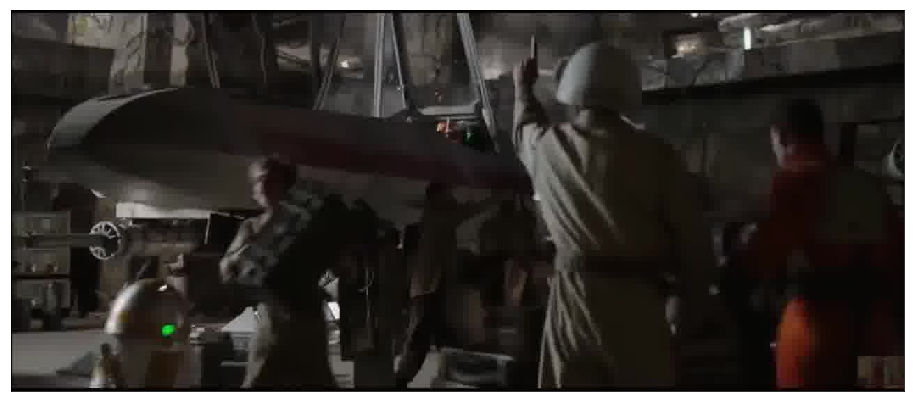

In [174]:
sample = next(iter(train_dl))
img = sample['org_img'][0].permute(1,2,0).numpy() * 255
img = img.astype(np.uint8)
show_img(img / 255, figsize=(16,8)), img.shape

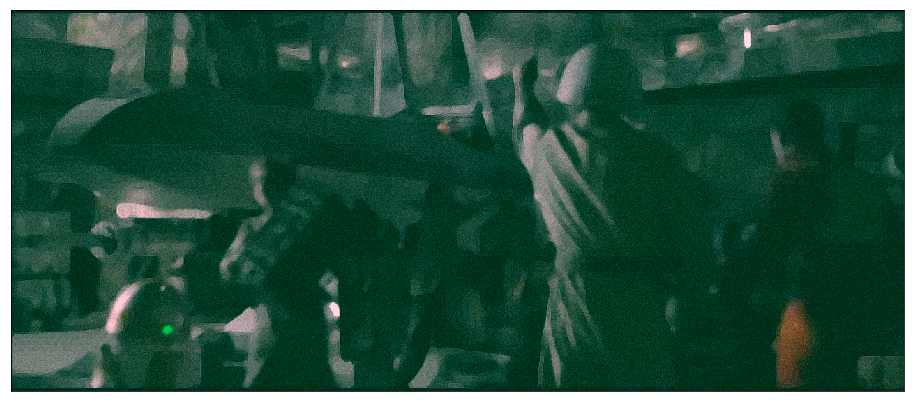

In [206]:
def aug(img):
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # Blur each image with varying strength using
            # gaussian blur (sigma between 0 and 3.0),
            # average/uniform blur (kernel size between 2x2 and 7x7)
            # median blur (kernel size between 3x3 and 11x11).
            iaa.OneOf([
                iaa.GaussianBlur((0, 3.0)),
                iaa.AverageBlur(k=(2, 7)),
                iaa.MedianBlur(k=(3, 11)),
            ]),
            # Sharpen each image, overlay the result with the original
            # image using an alpha between 0 (no sharpening) and 1
            # (full sharpening effect).
            sometimes(iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5))),
            # Add gaussian noise to some images.
            sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
            # Add a value of -5 to 5 to each pixel.
            sometimes(iaa.Add((-5, 5), per_channel=0.5)),
            # Change brightness of images (80-120% of original value).
            sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.5)),
            # Improve or worsen the contrast of images.
            sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)),
        ],
        # do all of the above augmentations in random order
        random_order=True
    )
    seq_det = seq.to_deterministic()
    img = seq_det.augment_images([img])[0]
    return img

show_img(aug(img) / 255, figsize=(16,8))

(128, 128, 3)


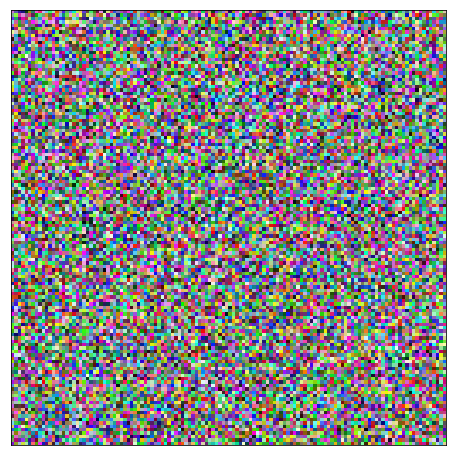

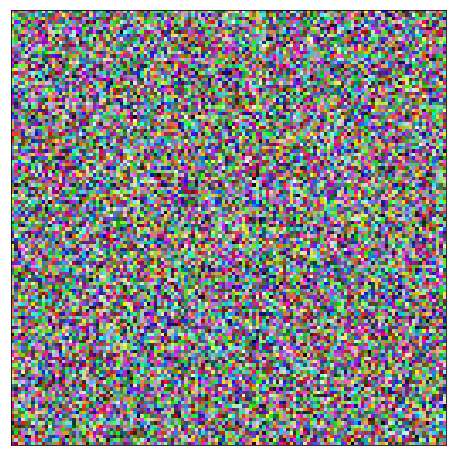

In [116]:
images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.GaussianBlur((0, 3.0)), iaa.MedianBlur(k=(3, 11))])

# show an image with 8*8 augmented versions of image 0
#seq.show_grid(images[0], cols=8, rows=8)

# Show an image with 8*8 augmented versions of image 0 and 8*8 augmented
# versions of image 1. The identical augmentations will be applied to
# image 0 and 1.
#seq.show_grid([images[0], images[1]], cols=8, rows=8)

print(images[0].shape)

show_img(images[0],  figsize=(16,8)) 
show_img(images[1],  figsize=(16,8)) 

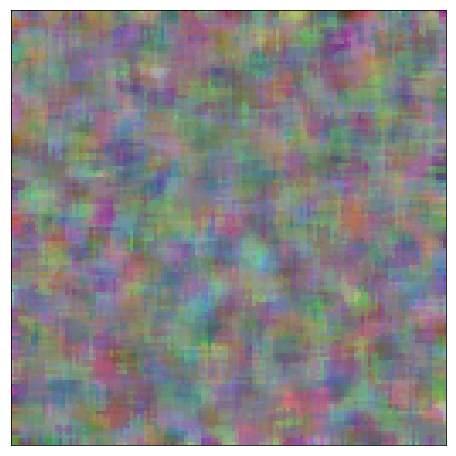

In [138]:
images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
seq = iaa.Sequential([ iaa.MedianBlur(k=(3, 11))])

seq_det = seq.to_deterministic()
images = seq_det.augment_images(images)

show_img(images[2],  figsize=(16,8)) 

In [124]:
class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    """
    def __init__(self, transforms=[]):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def add(self, transform):
        self.transforms.append(transform)


class ToTensor(object):
    def __init__(self, max_objects=50, is_debug=False):
        self.max_objects = max_objects
        self.is_debug = is_debug

    def __call__(self, sample):
        image, labels = sample['image'], sample['label']
        if self.is_debug == False:
            image = image.astype(np.float32)
            image /= 255.0
            image = np.transpose(image, (2, 0, 1))
            image = image.astype(np.float32)

        filled_labels = np.zeros((self.max_objects, 5), np.float32)
        filled_labels[range(len(labels))[:self.max_objects]] = labels[:self.max_objects]
        return {'image': torch.from_numpy(image), 'label': torch.from_numpy(filled_labels)}

class KeepAspect(object):
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        h, w, _ = image.shape
        dim_diff = np.abs(h - w)
        # Upper (left) and lower (right) padding
        pad1, pad2 = dim_diff // 2, dim_diff - dim_diff // 2
        # Determine padding
        pad = ((pad1, pad2), (0, 0), (0, 0)) if h <= w else ((0, 0), (pad1, pad2), (0, 0))
        # Add padding
        image_new = np.pad(image, pad, 'constant', constant_values=128)
        padded_h, padded_w, _ = image_new.shape

        # Extract coordinates for unpadded + unscaled image
        x1 = w * (label[:, 1] - label[:, 3]/2)
        y1 = h * (label[:, 2] - label[:, 4]/2)
        x2 = w * (label[:, 1] + label[:, 3]/2)
        y2 = h * (label[:, 2] + label[:, 4]/2)
        # Adjust for added padding
        x1 += pad[1][0]
        y1 += pad[0][0]
        x2 += pad[1][0]
        y2 += pad[0][0]
        # Calculate ratios from coordinates
        label[:, 1] = ((x1 + x2) / 2) / padded_w
        label[:, 2] = ((y1 + y2) / 2) / padded_h
        label[:, 3] *= w / padded_w
        label[:, 4] *= h / padded_h

        return {'image': image_new, 'label': label}

class ResizeImage(object):
    def __init__(self, new_size, interpolation=cv2.INTER_LINEAR):
        self.new_size = tuple(new_size) #  (w, h)
        self.interpolation = interpolation

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = cv2.resize(image, self.new_size, interpolation=self.interpolation)
        return {'image': image, 'label': label}

class ImageBaseAug(object):
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        self.seq = iaa.Sequential(
            [
                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                sometimes(iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5))),
                # Add gaussian noise to some images.
                sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
                # Add a value of -5 to 5 to each pixel.
                sometimes(iaa.Add((-5, 5), per_channel=0.5)),
                # Change brightness of images (80-120% of original value).
                sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.5)),
                # Improve or worsen the contrast of images.
                sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)),
            ],
            # do all of the above augmentations in random order
            random_order=True
        )

    def __call__(self, sample):
        seq_det = self.seq.to_deterministic()
        image, label = sample['image'], sample['label']
        image = seq_det.augment_images([image])[0]
        return {'image': image, 'label': label}